![image.png](https://i.imgur.com/a3uAqnb.png)

# PixelCNN
In this notebook, we will implement a **PixelCNN generative model** for the **Amazing Logos dataset**.

**PixelCNN** is an autoregressive generative model that learns to generate images **pixel by pixel** in a sequential manner. Unlike VAEs that learn a latent representation, PixelCNN directly models the probability distribution of pixels conditioned on previously generated pixels.

This notebook is heavily based on [This Repo](https://github.com/henrhoi/pixelcnn-pytorch/tree/master)

## 📌 **What is PixelCNN?**

**PixelCNN** is an autoregressive generative model that generates images pixel-by-pixel, where each pixel is predicted based on all previously generated pixels. The key innovation is using **masked convolutions** to ensure the autoregressive property.

### 🔹 **Key Concepts:**
1️⃣ **Autoregressive Generation**: Each pixel depends only on previous pixels (spatial causality)

2️⃣ **Masked Convolutions**: Prevents "seeing into the future" during training

3️⃣ **Sequential Generation**: Images are generated one pixel at a time

4️⃣ **No Latent Space**: Directly models pixel probabilities

![PixelCNN Concept](https://i.imgur.com/uABKvYM.png)

### 🔹 **PixelCNN vs VAE:**
| **PixelCNN** | **VAE** |
|--------------|---------|
| Autoregressive | Latent variable model |
| Pixel-by-pixel generation | Encode → Sample → Decode |
| No compression | Learns compressed representation |
| Slower generation | Faster generation |
| Often sharper images | Sometimes blurrier images |


In [22]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image

from tqdm import tqdm

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda



## 🎨 **Loading the Amazing Logos Dataset**

We'll use the **Amazing Logos** dataset from Hugging Face, which contains various logo designs. This is perfect for testing PixelCNN's ability to learn structured, symbolic patterns.

### 🔹 **Dataset Details:**
- **Source**: `iamkaikai/amazing_logos` from Hugging Face
- **Content**: Various logo designs and brand symbols
- **Challenge**: Logos have sharp edges, text, and geometric patterns
- **Preprocessing**: Convert to grayscale → Binary (black/white) for simplicity

In [24]:
class LogoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for Amazing Logos from Hugging Face

    This dataset contains various logo images that we'll use for autoregressive generation.
    PixelCNN learns to predict each pixel sequentially based on previously generated pixels.
    """

    def __init__(self, dataset, transform=None, image_size=64):
        """
        Args:
            dataset: Hugging Face dataset object
            transform: Image transformations to apply
            image_size: Target size for resizing images (default: 64x64)
        """
        self.dataset = dataset
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get image from dataset
        image = self.dataset[idx]['image']
        # Convert to PIL Image if needed
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        elif not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')

        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image

### 🔹 **Image Preprocessing Pipeline**


In [29]:
# Define image transformations for logo processing
# We resize to a smaller size (64x64) for faster training and convert to binary
transform = transforms.Compose([
    transforms.Resize((64, 64)),           # Resize to 64x64 for manageable computation
    transforms.ToTensor(),                 # Convert PIL Image to tensor [0,1]
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale for simplicity
])

# Load the Amazing Logos dataset
hf_dataset = load_dataset("iamkaikai/amazing_logos", split="train[:1000]")
print(f"Dataset loaded successfully! Total images: {len(hf_dataset)}")

# Create custom dataset with transformations
logo_dataset = LogoDataset(hf_dataset, transform=transform)

# Convert to binary images (black and white) for PixelCNN
# This simplifies the learning task to binary classification per pixel
def binarize_batch(batch):
    """Convert grayscale images to binary (0 or 1) based on threshold"""
    return (batch > 0.5).float()

# Create data loader for training
batch_size = 128  
train_loader = DataLoader(logo_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Training samples: {len(logo_dataset)}")
print(f"Batch size: {batch_size}")

Dataset loaded successfully! Total images: 1000
Training samples: 1000
Batch size: 128


In [30]:
next(iter(train_loader)).shape

torch.Size([128, 1, 64, 64])

### 📊 **Let's visualize the dataset**


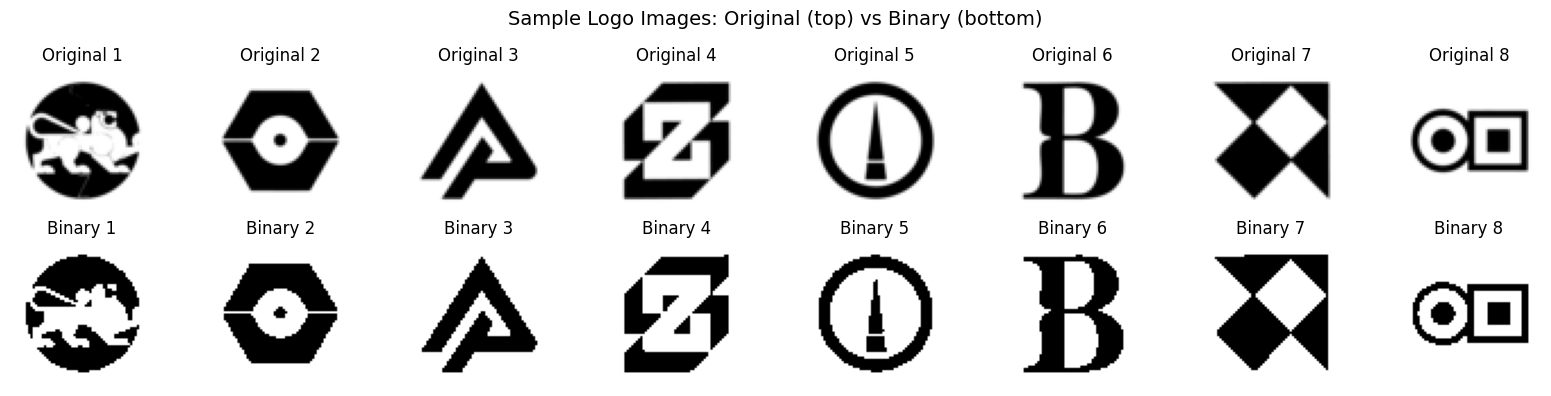

Image tensor shape: torch.Size([1, 64, 64])


In [31]:
# Display sample logo images to verify data loading
data_iter = iter(train_loader)
sample_images = next(data_iter)
sample_images_binary = binarize_batch(sample_images)

# Show original and binarized images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original grayscale images (top row)
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Binary images (bottom row) - what PixelCNN will learn
    axes[1, i].imshow(sample_images_binary[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Binary {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Sample Logo Images: Original (top) vs Binary (bottom)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Image tensor shape: {sample_images[0].shape}") 

## 🏗️ **Defining the PixelCNN Model**

### 🔹 **Understanding Masked Convolutions**

The core innovation of PixelCNN is **masked convolutions** that maintain the autoregressive property:

![Masked Convolution](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)

- **Type A Mask**: Used in first layer, masks current pixel and all future pixels
- **Type B Mask**: Used in subsequent layers, allows current pixel but masks future pixels


In [32]:
class MaskedConv2d(nn.Conv2d):
    """
    🎭 Masked Convolution for autoregressive generation

    This is the CORE component of PixelCNN that ensures the autoregressive property:
    - Type A mask: Used in the first layer, masks the current pixel and all future pixels
    - Type B mask: Used in subsequent layers, allows the current pixel but masks future pixels

    The masking ensures that when predicting pixel (i,j), we only use information from:
    - All pixels in rows < i
    - Pixels in row i with columns < j (for type A) or <= j (for type B)
    """

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        """
        Args:
            mask_type: 'A' or 'B' - determines which pixels are masked
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_size: Size of convolution kernel
            padding: Padding for convolution
        """
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)

        # Register mask as a buffer (not a parameter, but part of model state)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        h, w = kernel_size, kernel_size
        center_h, center_w = h // 2, w // 2

        if mask_type == 'A':
            # Type A: Mask current pixel and all future pixels
            # Used in the first layer to ensure strict autoregressive property
            self.mask[:, :, center_h, center_w:] = 0      # Mask current and future pixels in center row
            self.mask[:, :, center_h + 1:, :] = 0         # Mask all future rows
        else:  # Type B
            # Type B: Allow current pixel but mask future pixels
            # Used in subsequent layers - current pixel can see itself through residual connections
            self.mask[:, :, center_h, center_w + 1:] = 0  # Mask only future pixels in center row
            self.mask[:, :, center_h + 1:, :] = 0         # Mask all future rows

    def forward(self, x):
        """Apply mask to weights before convolution"""
        # Element-wise multiply weights with mask to zero out future connections
        self.weight.data *= self.mask
        return super().forward(x)

In [33]:
class PixelCNN(nn.Module):
    """
    🎨 PixelCNN for Logo Generation

    PixelCNN is an autoregressive generative model that learns to generate images pixel by pixel.
    It uses masked convolutions to ensure that each pixel is predicted based only on previously
    generated pixels, maintaining the autoregressive property.

    🏗️ Architecture:
    1. One 7x7 Type-A masked convolution (ensures autoregressive property)
    2. Multiple 7x7 Type-B masked convolutions (main feature extraction)
    3. Two 1x1 convolutions (final processing and output)

    📊 Expected Input & Output Shapes:
    - Input: (batch_size, 1, 64, 64) - Binary logo images
    - Output: (batch_size, 1, 64, 64) - Pixel probabilities [0,1]
    """

    def __init__(self, in_channels=1, conv_filters=64):
        """
        Args:
            in_channels: Number of input channels (1 for grayscale, 3 for RGB)
            conv_filters: Number of filters in convolutional layers
        """
        super().__init__()

        self.net = nn.Sequential(
            # 🔴 First layer: 7x7 A-type convolution
            # This layer establishes the autoregressive property by masking current pixel
            MaskedConv2d('A', in_channels=in_channels, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),

            # 🔵 Five 7x7 B-type convolutions for feature extraction
            # These layers can see the current pixel but maintain autoregressive property
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),

            # 🟡 Two 1x1 B-type convolutions for final processing
            # 1x1 convolutions help combine features and reduce to output channels
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=in_channels, kernel_size=1),

            # 🎯 Sigmoid activation to output probabilities for each pixel
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through PixelCNN

        Args:
            x: Input tensor of shape (batch_size, channels, height, width)

        Returns:
            Output tensor with same shape, containing pixel probabilities
        """
        return self.net(x)

## 🚀 **Training the PixelCNN Model**

### 🔹 **Training Process Explained**

PixelCNN training is different from VAE:
1. **Input**: Binary logo images
2. **Target**: Same binary logo images (reconstruction task)
3. **Loss**: Binary Cross-Entropy between predicted and actual pixels
4. **Key**: Autoregressive property ensures proper causality


In [34]:
# 🛠️ Helper functions for training

def normalize_for_model(x):
    """
    Normalize input for model training
    PixelCNN expects input in range [-1, 1] for better training dynamics
    """
    return 2 * (x - 0.5)

def binary_cross_entropy_loss(output, target):
    """
    Compute binary cross-entropy loss between predicted and target pixels

    Args:
        output: Model predictions (probabilities)
        target: Ground truth binary images

    Returns:
        Binary cross-entropy loss
    """
    return torch.nn.functional.binary_cross_entropy(output, target)

def get_batched_loss(dataset, model, batch_size=128):
    """
    📊 Compute average loss over entire dataset in batches

    This function is used to evaluate model performance on test data
    without loading all data into memory at once.
    """
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            # Get batch
            end_idx = min(i + batch_size, len(dataset))
            batch = torch.stack([dataset[j] for j in range(i, end_idx)])
            batch = binarize_batch(batch).to(device)

            # Forward pass
            output = model(normalize_for_model(batch))
            loss = binary_cross_entropy_loss(output, batch)

            total_loss += loss.item()
            num_batches += 1

    model.train()
    return total_loss / num_batches

### ⚙️ **Training Configuration**


In [50]:
# 🎛️ Training hyperparameters
n_epochs = 200                    # Number of training epochs
learning_rate = 1e-3            # Learning rate for optimizer
n_channels = 1                  # Number of input channels (grayscale)
convolution_filters = 128        # Number of filters in conv layers


# Initialize model and optimizer
pixelcnn = PixelCNN(n_channels, convolution_filters).to(device)
optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=learning_rate)

# Print model information
total_params = sum(p.numel() for p in pixelcnn.parameters())
print(f"- Total Parameters: {total_params:,}")

# Initialize loss tracking
train_losses = []


- Total Parameters: 4,037,761


### 🏃‍♂️ **Training Loop**


In [51]:
for epoch in range(n_epochs):
    epoch_losses = []

    # Training loop with progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}")

    for batch_idx, batch_images in enumerate(progress_bar):
        # Prepare batch data
        batch_images = binarize_batch(batch_images).to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: predict pixel probabilities
        output = pixelcnn(normalize_for_model(batch_images))

        # Compute loss: how well do predictions match ground truth?
        loss = binary_cross_entropy_loss(output, batch_images)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Record loss
        epoch_losses.append(loss.item())
        train_losses.append(loss.item())

        # Update progress bar with current loss
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Print epoch summary
    avg_epoch_loss = np.mean(epoch_losses)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1:2d}/{n_epochs} completed | Average Loss: {avg_epoch_loss:.4f}")

print("\n✅ Training completed successfully!")

Epoch 10/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s, Loss=0.1877]


Epoch 10/200 completed | Average Loss: 0.1878


Epoch 20/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s, Loss=0.0994]


Epoch 20/200 completed | Average Loss: 0.1056


Epoch 30/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.19it/s, Loss=0.0831]


Epoch 30/200 completed | Average Loss: 0.0884


Epoch 40/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s, Loss=0.0675]


Epoch 40/200 completed | Average Loss: 0.0772


Epoch 50/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s, Loss=0.0680]


Epoch 50/200 completed | Average Loss: 0.0746


Epoch 60/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18it/s, Loss=0.0690]


Epoch 60/200 completed | Average Loss: 0.0734


Epoch 70/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.82it/s, Loss=0.0680]


Epoch 70/200 completed | Average Loss: 0.0696


Epoch 80/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s, Loss=0.0651]


Epoch 80/200 completed | Average Loss: 0.0688


Epoch 90/200: 100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.42it/s, Loss=0.0676]


Epoch 90/200 completed | Average Loss: 0.0674


Epoch 100/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.36it/s, Loss=0.0713]


Epoch 100/200 completed | Average Loss: 0.0670


Epoch 110/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s, Loss=0.0556]


Epoch 110/200 completed | Average Loss: 0.0653


Epoch 120/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s, Loss=0.0640]


Epoch 120/200 completed | Average Loss: 0.0655


Epoch 130/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s, Loss=0.0625]


Epoch 130/200 completed | Average Loss: 0.0648


Epoch 140/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.82it/s, Loss=0.0642]


Epoch 140/200 completed | Average Loss: 0.0637


Epoch 150/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.84it/s, Loss=0.0638]


Epoch 150/200 completed | Average Loss: 0.0633


Epoch 160/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.32it/s, Loss=0.0664]


Epoch 160/200 completed | Average Loss: 0.0629


Epoch 170/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s, Loss=0.0567]


Epoch 170/200 completed | Average Loss: 0.0618


Epoch 180/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.34it/s, Loss=0.0560]


Epoch 180/200 completed | Average Loss: 0.0612


Epoch 190/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.14it/s, Loss=0.0646]


Epoch 190/200 completed | Average Loss: 0.0614


Epoch 200/200: 100%|█████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.74it/s, Loss=0.0575]

Epoch 200/200 completed | Average Loss: 0.0611

✅ Training completed successfully!


### 📈 **Training Loss Visualization**


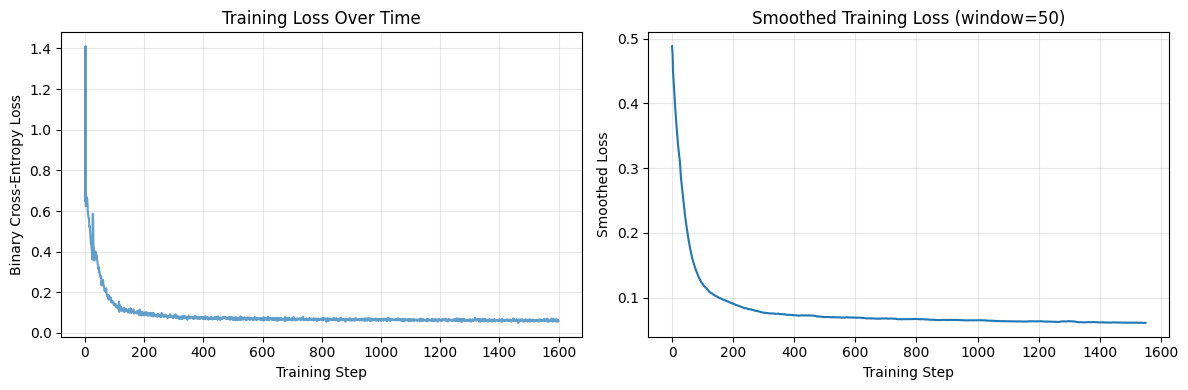

In [52]:
# Plot training losses
plt.figure(figsize=(12, 4))

# Plot 1: Loss over all training steps
plt.subplot(1, 2, 1)
plt.plot(train_losses, alpha=0.7)
plt.title("Training Loss Over Time")
plt.xlabel("Training Step")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True, alpha=0.3)

# Plot 2: Smoothed loss (moving average)
window_size = 50
if len(train_losses) > window_size:
    smoothed_losses = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(smoothed_losses)
    plt.title(f"Smoothed Training Loss (window={window_size})")
    plt.xlabel("Training Step")
    plt.ylabel("Smoothed Loss")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎨 **Generating New Logo Samples**

### 🔹 **Autoregressive Generation Process**

This is where the magic happens! PixelCNN generates images **pixel by pixel** in a specific order:

1. **Start**: With blank canvas (all zeros)
2. **For each pixel position** (top→bottom, left→right):
   - Use model to predict probability of pixel being 1
   - Sample from Bernoulli distribution using this probability
   - Add sampled pixel to canvas
3. **Repeat**: Until entire image is generated

![Generation Process](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-16_at_7.27.51_PM_tpsd8Td.png)

In [53]:
def generate_logos(model, num_samples=16, image_size=64):
    """
    🎨 Generate new logo images using trained PixelCNN

    This function implements the autoregressive generation process:
    1. Start with blank canvas (all zeros)
    2. For each pixel position (top-to-bottom, left-to-right):
        - Use model to predict probability of pixel being 1
        - Sample from Bernoulli distribution using this probability
        - Add sampled pixel to canvas
    3. Repeat until entire image is generated

    Args:
        model: Trained PixelCNN model
        num_samples: Number of logos to generate
        image_size: Size of generated images

    Returns:
        Generated logo images as numpy array
    """

    # Clear GPU memory
    torch.cuda.empty_cache()

    # Initialize blank canvas
    H, W = image_size, image_size
    samples = torch.zeros(size=(num_samples, 1, H, W)).to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Generate pixel by pixel (autoregressive generation)
        total_pixels = H * W
        progress_bar = tqdm(total=total_pixels, desc="Generating pixels")

        for i in range(H):  # For each row
            for j in range(W):  # For each column
                # Get model predictions for current state
                output = model(normalize_for_model(samples))

                # Sample pixel value using Bernoulli distribution
                # torch.bernoulli samples 0 or 1 based on predicted probability
                pixel_probs = output[:, :, i, j]
                sampled_pixels = torch.bernoulli(pixel_probs)
                samples[:, :, i, j] = sampled_pixels

                progress_bar.update(1)

        progress_bar.close()

    # Convert to numpy for visualization
    samples = samples.detach().cpu().numpy()
    samples = np.transpose(samples, [0, 2, 3, 1])  # (N, H, W, C)

    return samples

In [54]:
generated_samples = generate_logos(pixelcnn, num_samples=16, image_size=64)

Generating pixels: 100%|████████████████████████████████████████████████████████████| 4096/4096 [01:13<00:00, 56.03it/s]


### 🖼️ **Displaying Generated Results**


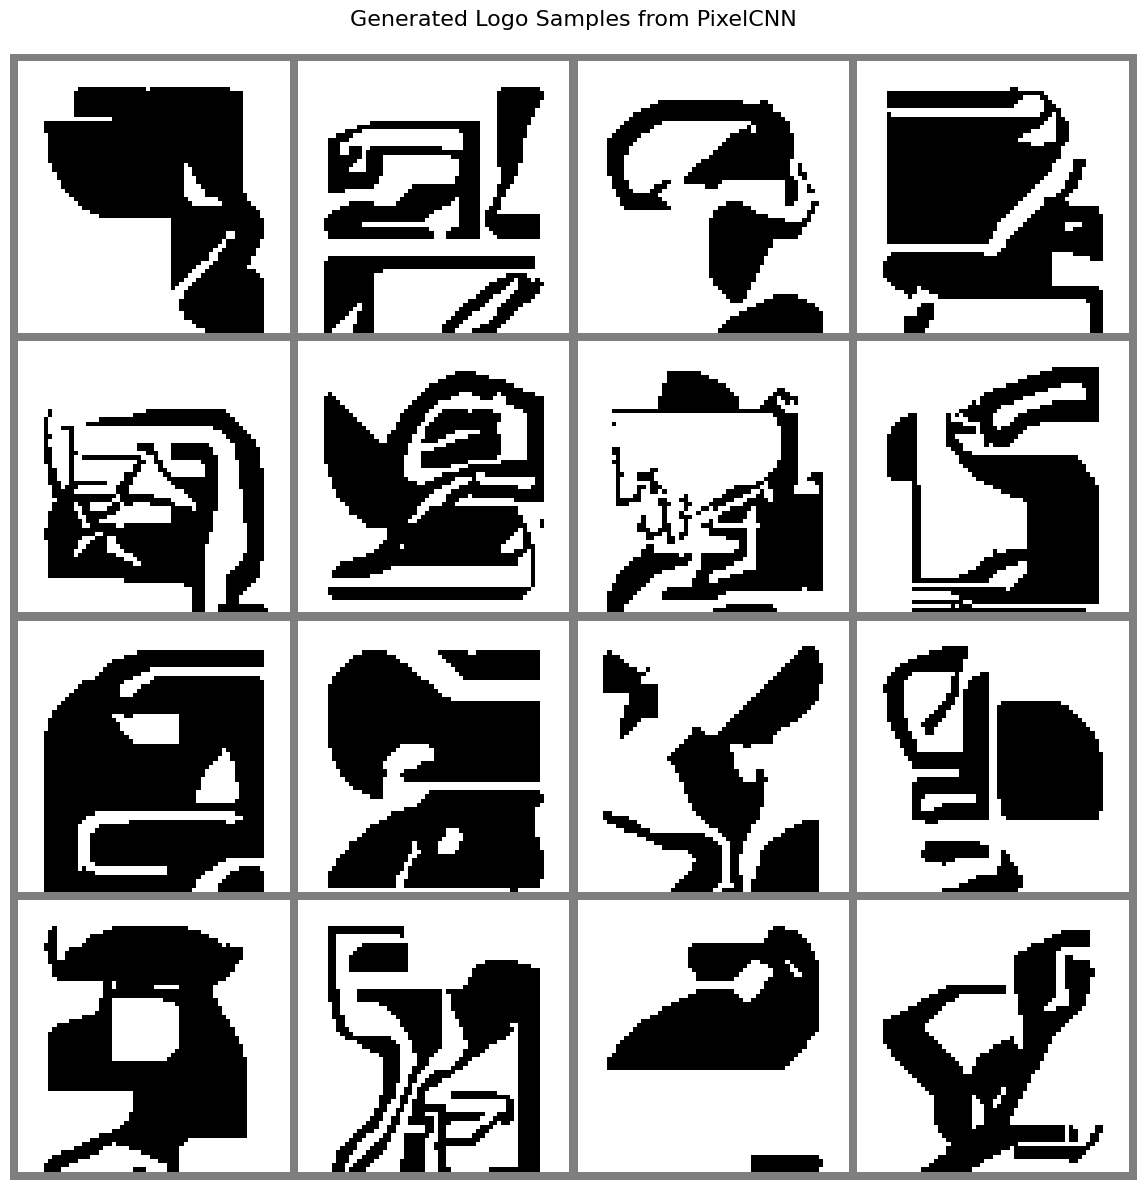

In [55]:
# Display generated logos
samples_tensor = torch.FloatTensor(generated_samples).permute(0, 3, 1, 2)
grid_img = make_grid(samples_tensor, nrow=4, padding=2, pad_value=0.5)

plt.figure(figsize=(12, 12))
plt.title("Generated Logo Samples from PixelCNN", fontsize=16, pad=20)
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## 🧪 **Experiments to Try**

### 📝 **Suggested Modifications:**
1. **Model Size**: Try different `conv_filters` (32, 128, 256)
2. **Image Resolution**: Experiment with 32x32 vs 128x128 images
3. **Color Channels**: Extend to RGB logos (3 channels)
    - THIS IS HARD, WALLAHI.
    - If you want to see one that actually worked [OpenAI Implementation of PixelCNN in Tensorflow](https://github.com/openai/pixel-cnn)
4. **Architecture**: Add more layers or residual connections
5. **Training**: Longer training (200+ epochs) for better quality

### Contributed by: Ali Habibullah. 